MultiRAT dataset description code
================
Joanes Grandjean

![rat art](../assets/img/rat_art.png)

This page shows the code to reproduce the figures in the manuscript in preparation. Results/figure selection is based on the analysis in the other scripts.  

In [157]:
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from nilearn import plotting
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.api import qqplot
from scipy.stats import chi2_contingency
from math import sqrt

# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/multiRat_rest_20211208.tsv'

df = pd.read_csv(df_path, sep='\t')
df_exclude = df.loc[(df['exclude'] != 'yes')]

# color palette for all plots except voxelwise. 
sns.set_palette("colorblind")

## from https://stackoverflow.com/questions/50506076/is-there-an-efficient-way-to-store-2d-plots-as-a-vector-graphic-in-python
new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 6
mm = (1/2.54)*10

# combine jet colormap for plot_stat_map (see https://stackoverflow.com/a/31052741)
# select to color scheme to use
colors1 = plt.cm.viridis(np.linspace(0., 1, 128))
colors = np.vstack((colors1, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)


# Figure 1. Dataset description.
a. Strain.  
b. Sex.   
c. Anesthesia.   
d. Field strength.   
e. Breathing rate as a function of anesthesia.    
f. Repetition time as a function of sequence   
g. Echo time as a function of sequence.   

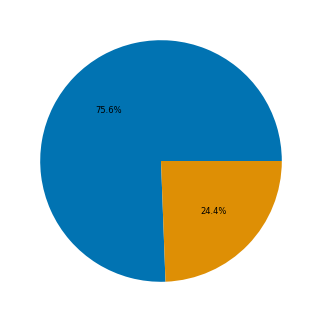

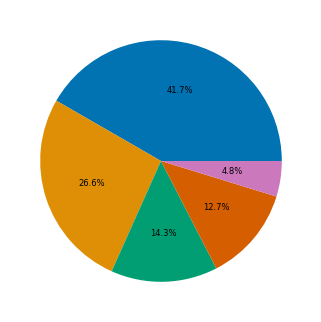

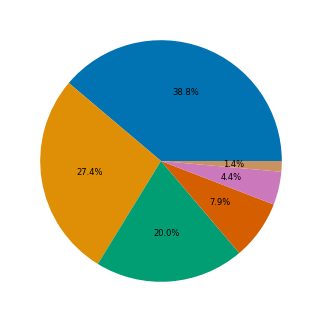

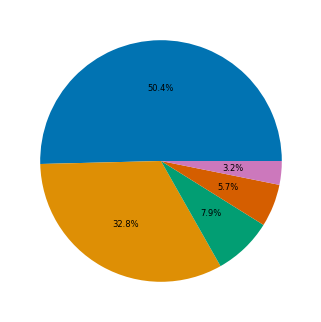

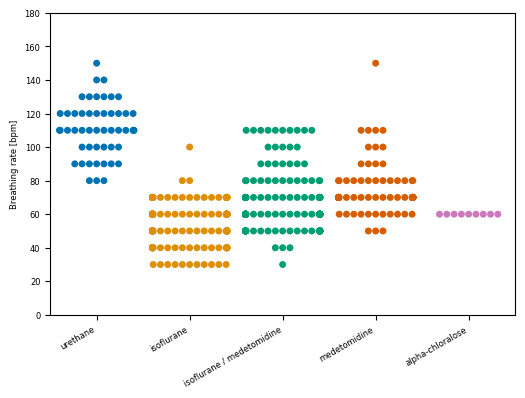

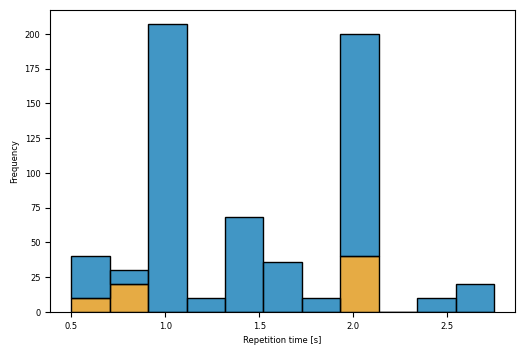

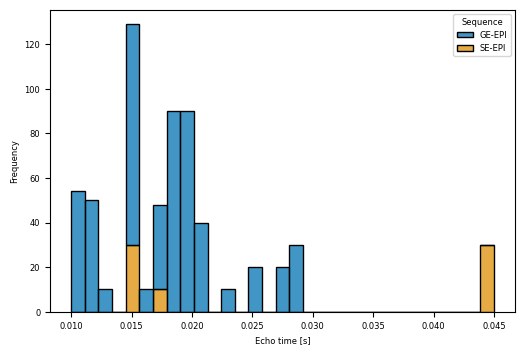

In [23]:
## Figure 1A
plt.pie(df['rat.sex'].value_counts(), autopct="%.1f%%")
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1A.svg'), format="svg", dpi=600)
plt.show()

## Figure 1B
plt.pie(df['rat.strain'].value_counts(), autopct="%.1f%%")
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1B.svg'), format="svg", dpi=600)
plt.show()

## Figure 1C
plt.pie(df['anesthesia.maintenance'].value_counts(), autopct="%.1f%%")
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1C.svg'), format="svg", dpi=600)
plt.show()

## Figure 1D
plt.pie(df['MRI.field.strength'].value_counts(), autopct="%.1f%%")
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1D.svg'), format="svg", dpi=600)
plt.show()

## Figure 1E
df_tmp = df.dropna(subset=['anesthesia.breathing.rate'])
snp = sns.swarmplot(x="anesthesia.maintenance", y="anesthesia.breathing.rate", data=df_tmp)
snp.set_xticklabels(snp.get_xticklabels(), rotation=30, ha='right')
snp.set_xlabel("")
snp.set_ylabel("Breathing rate [bpm]")
snp.set(ylim=(0, 180))

plt.savefig(os.path.join(init_folder,'assets','figure','Figure1E.svg'), format="svg", dpi=600)
plt.show()

## Figure 1F
snp = sns.histplot(data=df, x="func.TR", hue="func.sequence", multiple="stack")
snp.set_xlabel("Repetition time [s]")
snp.set_ylabel("Frequency")
snp.get_legend().remove()
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1F.svg'), format="svg", dpi=600)
plt.show()

## Figure 1G
snp = sns.histplot(data=df, x="func.TE", hue="func.sequence", multiple="stack")
snp.set_xlabel("Echo time [s]")
snp.set_ylabel("Frequency")
snp.get_legend().set_title('Sequence')
plt.savefig(os.path.join(init_folder,'assets','figure','Figure1G.svg'), format="svg", dpi=600)
plt.show()


# Figure S1. Dataset description complement
a. Age in months   
b. Weight in g   


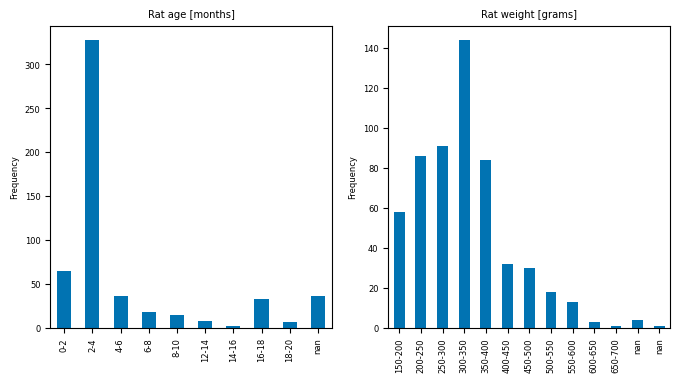

In [24]:
df_age= df['rat.age'].value_counts().rename_axis('age').reset_index(name='counts')
df_age['age'] = pd.Categorical(df_age['age'], ["0-2", "2-4", "4-6","6-8","8-10","10-12","12-14","14-16","16-18","18-20"])

df_weight= df['rat.weight'].value_counts().rename_axis('weight').reset_index(name='counts')
df_weight['weight'] = pd.Categorical(df_weight['weight'] , ["150-200", 
                                                            "200-250", 
                                                            "250-300",
                                                            "300-350",
                                                            "350-400",
                                                            "400-450",
                                                            "450-500",
                                                            "500-550",
                                                            "550-600",
                                                            "600-650",
                                                            "650-700"])


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))



ax3 = df_age.sort_values(by=['age']).plot.bar(x='age',y='counts', title='Rat age [months]',ax=axes[0])
ax4 = df_weight.sort_values(by=['weight']).plot.bar(x='weight',y='counts', title='Rat weight [grams]',ax=axes[1])

ax3.set(xlabel="", ylabel="Frequency")
ax4.set(xlabel="", ylabel="Frequency")
ax3.get_legend().remove()
ax4.get_legend().remove()

plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS1.svg'), format="svg", dpi=600)
plt.show()

# Figure S2. Failed QA
a. Anatomical to template   
b. Functional to anatomical   


#### Failed anatomical to template registration

![func2anat](../assets/QC/sub-0104600_ses-1_T2w_inho_cor_registration.png)


#### Failed functional to anatomical registration

![func2anat](../assets/QC/sub-0101502_ses-1_run-1_bold_registration.png)

![func2anat](../assets/QC/sub-0104304_ses-1_run-1_bold_registration.png)

![func2anat](../assets/QC/sub-0104601_ses-1_run-1_bold_registration.png)

# Figure S3. tSNR
a. tSNR as a function of field strength   
b. tSNR as a function of repetition time   
c. tSNR as a function of echo time   
d. tSNR in the S1 and striatum   

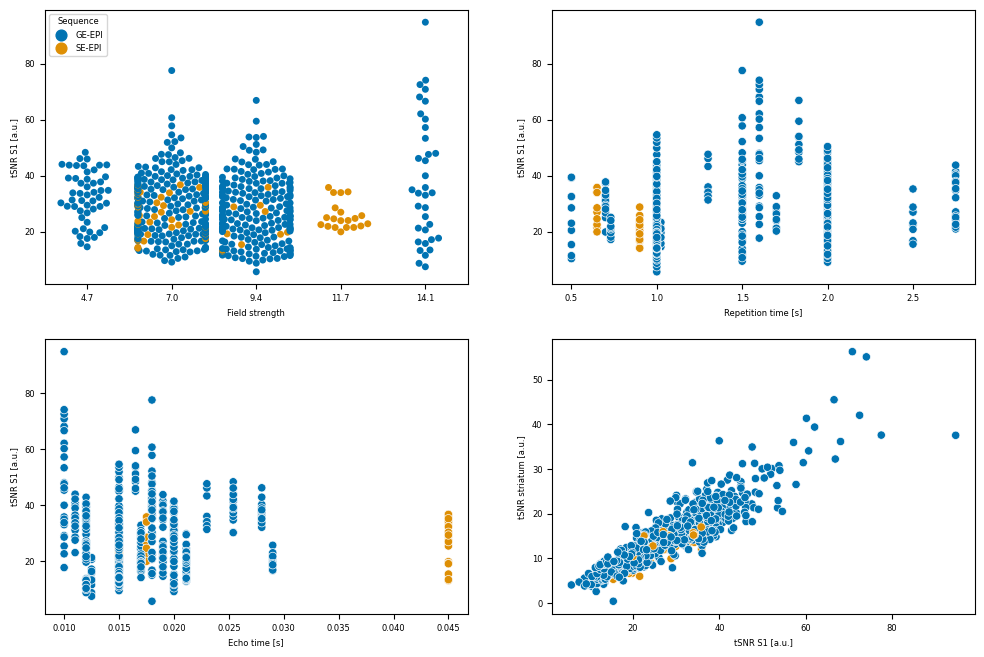

In [2]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 8))

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="MRI.field.strength",
                    y="tsnr.S1", hue="func.sequence",ax=axes[0,0])
ax2 = sns.scatterplot(data=df_exclude, x="func.TR",
                    y="tsnr.S1", hue="func.sequence",ax=axes[0,1])
ax3 = sns.scatterplot(data=df_exclude, x="func.TE",
                    y="tsnr.S1", hue="func.sequence",ax=axes[1,0])
ax4 = sns.scatterplot(data=df_exclude, x="tsnr.S1",
                    y="tsnr.str", hue="func.sequence",ax=axes[1,1])

ax1.set(xlabel='Field strength', ylabel='tSNR S1 [a.u.]')
ax1.get_legend().set_title('Sequence')

ax2.set(xlabel='Repetition time [s]', ylabel='tSNR S1 [a.u.]')
ax2.get_legend().remove()

ax3.set(xlabel='Echo time [s]', ylabel='tSNR S1 [a.u.]')
ax3.get_legend().remove()

ax4.set(xlabel='tSNR S1 [a.u.]', ylabel='tSNR striatum [a.u.]')
ax4.get_legend().remove()

plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS3.svg'), format="svg", dpi=600)
plt.show()

# Figure S4 Motion
a. Mean framewise displacement as a function of strain   
b. Mean framewise displacement as a function of anesthesia   
c. Mean framewise displacement as a function of breathing rate   
d. Mean framewise displacement as a function of maximal framewise displacement   

correlation between mean and max FW
0.5976719356349764


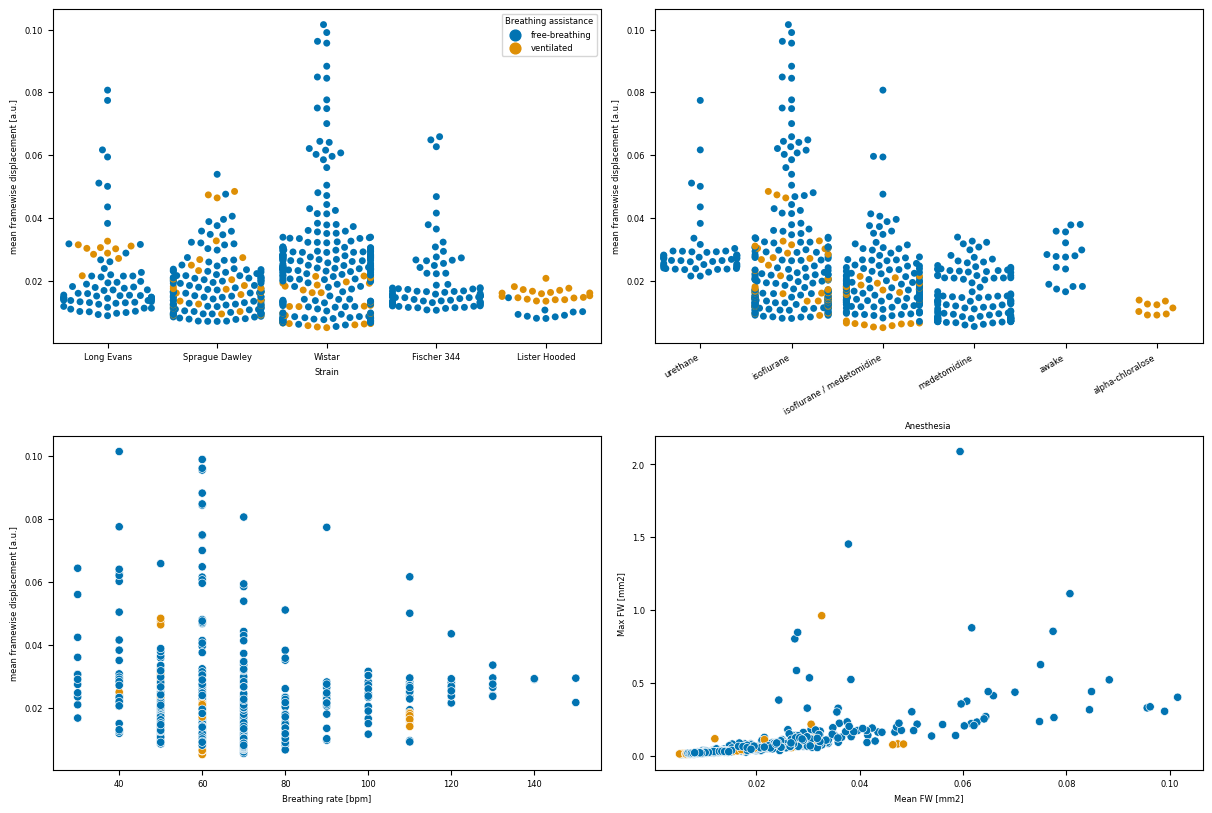

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(12, 8),constrained_layout=True)

sns.set_palette("colorblind")


ax1 = sns.swarmplot(data=df_exclude, x="rat.strain",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[0,0])
ax2 = sns.swarmplot(data=df_exclude, x="anesthesia.maintenance",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[0,1])
ax3 = sns.scatterplot(data=df_exclude, x="anesthesia.breathing.rate",
                    y="MFW", hue="anesthesia.breathing.assistance",ax=axes[1,0])
ax4 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="maxFW", hue="anesthesia.breathing.assistance",ax=axes[1,1])


ax1.set(xlabel='Strain', ylabel='mean framewise displacement [a.u.]')
ax1.get_legend().set_title('Breathing assistance')

ax2.set(xlabel='Anesthesia', ylabel='mean framewise displacement [a.u.]')
ax2.get_legend().remove()
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30, ha='right')

ax3.set(xlabel='Breathing rate [bpm]', ylabel='mean framewise displacement [a.u.]')
ax3.get_legend().remove()

ax4.set(xlabel='Mean FW [mm2]', ylabel='Max FW [mm2]')
ax4.get_legend().remove()

print('correlation between mean and max FW')
print(df_exclude[['MFW','maxFW']].corr().iloc[0,1])

plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS4.svg'), format="svg", dpi=600)
plt.show()

# Figure 2 Seed-based analysis
a. Diagram illustrating the logic behind FC specificity   
b. example time serie
c. FC specificity as a function of nuisance regression  
d. FC relative to specific and unspecific ROI
e.  example images
f. FC incidence map   
g. test-retest (skip?)   

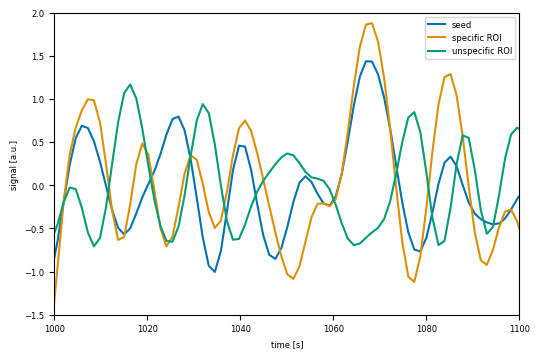

In [27]:
## Figure 2B

TR=1.3
seed = np.loadtxt('../assets/figure/S1bf_l_0104608.txt')
specific = np.loadtxt('../assets/figure/S1bf_r_0104608.txt')
unspecific = np.loadtxt('../assets/figure/ACA_l_0104608.txt')
time = np.arange(1, len(seed)*TR, TR)


plt.plot(time,seed,label='seed')
plt.plot(time,specific,label='specific ROI')
plt.plot(time,unspecific,label='unspecific ROI')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('signal [a.u.]')
#plt.xlim(200,300) #not a keep
#plt.xlim(330,430) #not bad either
#plt.xlim(700,800) #not bad
plt.xlim(1000,1100)
plt.ylim(-1.5,2)
plt.savefig(os.path.join(init_folder,'assets','figure','Figure2B.svg'), format="svg", dpi=600)
plt.show()

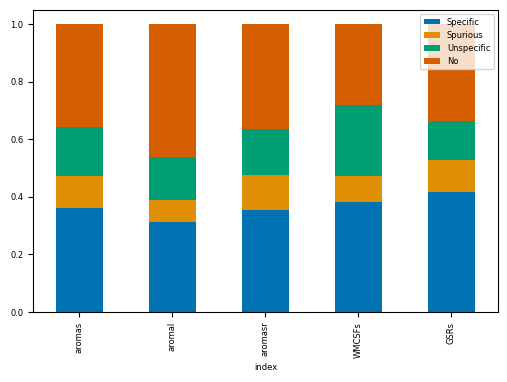

In [28]:
specificity_denoise= pd.concat([df_exclude['aromas_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromal_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromasr_S1bf_cat'].value_counts(sort=False),
                                df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False),
                                df_exclude['GSRs_S1bf_cat'].value_counts(sort=False)], axis=1)

specificity_denoise = specificity_denoise/specificity_denoise.sum()
specificity_denoise = specificity_denoise.rename(columns={"aromas_S1bf_cat": "aromas", "aromal_S1bf_cat": "aromal", "aromasr_S1bf_cat": "aromasr", "WMCSFs_S1bf_cat": "WMCSFs", "GSRs_S1bf_cat": "GSRs"})

specificity_denoise_T = specificity_denoise.T
specificity_denoise_T.reset_index(level=0, inplace=True) 
specificity_denoise_T = specificity_denoise_T[["index","Specific", "Spurious", "Unspecific","No"]]

specificity_denoise_T.set_index('index').plot(kind='bar', stacked=True)

plt.savefig(os.path.join(init_folder,'assets','figure','Figure2C.svg'), format="svg", dpi=600)
plt.show()

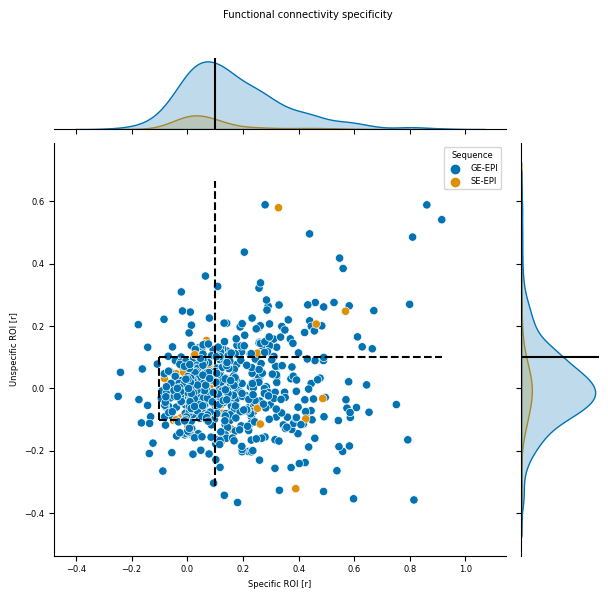

In [29]:
## Figure 2d
ax6 = sns.jointplot(data=df_exclude, x='GSRs_S1bf_S1bf', y='GSRs_S1bf_ACA', hue='func.sequence')
#ax6.plot_joint(sns.kdeplot,linestyles='dashed', zorder=0, levels=6)

ax6.fig.suptitle('Functional connectivity specificity')
ax6.fig.subplots_adjust(top=0.9)
ax6.ax_joint.set(xlabel='Specific ROI [r]', ylabel='Unspecific ROI [r]')
ax6.ax_joint.get_legend().set_title('Sequence')
ax6.ax_joint.vlines(0.1,ymin=min(df_exclude['WMCSFs_S1bf_ACA']),ymax=max(df_exclude['WMCSFs_S1bf_ACA']),linestyles='dashed', color='black')
ax6.ax_joint.vlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(0.1, -0.1,xmax=max(df_exclude['GSRs_S1bf_S1bf']),linestyles='dashed', color='black')
ax6.ax_marg_x.axvline(x=0.1, color='black')
ax6.ax_marg_y.axhline(y=0.1, color='black')

plt.savefig(os.path.join(init_folder,'assets','figure','Figure2D_GSRs.svg'), format="svg", dpi=600)
plt.show()

In [30]:
## Figure 2e

bg_img=os.path.join(analysis_folder, 
             'template',
             'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
             'SIGMA_Rat_Anatomical_Imaging',
            'SIGMA_Rat_Anatomical_InVivo_Template',
            'SIGMA_InVivo_Brain_Template_Masked.nii')


seed_list = glob.glob((os.path.join(analysis_folder, 'export', 'seed','*'))+'/*')
#only keep WMCSFs seed maps
r = re.compile('/GSRs/')
seed_list_sub=list(filter(r.findall, seed_list))
# only keep S1bf seed maps
r = re.compile('S1bf')
seed_list_sub=list(filter(r.findall, seed_list_sub))

# keep specific example
r = re.compile('104608')
seed_list_sub_select=list(filter(r.findall, seed_list_sub))
r = re.compile('ses-1')
seed_list_sub_specific=list(filter(r.findall, seed_list_sub_select))
plotting.plot_stat_map(seed_list_sub_select[0], 
                           bg_img, 
                           title='Specific FC, ID: 104608 ses: 1',
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5),
                           output_file=os.path.join(init_folder,'assets','figure','Figure2E_specific.svg'))

# keep unspecific example
r = re.compile('102304')
seed_list_sub_select=list(filter(r.findall, seed_list_sub))
r = re.compile('ses-1')
seed_list_sub_specific=list(filter(r.findall, seed_list_sub_select))
plotting.plot_stat_map(seed_list_sub_select[0], 
                           bg_img, 
                           title='Unspecific FC, ID: 102102 ses: 1',
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5),
                           output_file=os.path.join(init_folder,'assets','figure','Figure2E_unspecific.svg'))

# keep no example
r = re.compile('104307')
seed_list_sub_select=list(filter(r.findall, seed_list_sub))
r = re.compile('ses-1')
seed_list_sub_specific=list(filter(r.findall, seed_list_sub_select))
plotting.plot_stat_map(seed_list_sub_select[0], 
                           bg_img, 
                           title='No FC, ID: 104307 ses: 1',
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5),
                           output_file=os.path.join(init_folder,'assets','figure','Figure2E_no.svg'))

# keep Spurious example
r = re.compile('102506')
seed_list_sub_select=list(filter(r.findall, seed_list_sub))
r = re.compile('ses-1')
seed_list_sub_specific=list(filter(r.findall, seed_list_sub_select))
plotting.plot_stat_map(seed_list_sub_select[0], 
                           bg_img, 
                           title='Spurious FC, ID: 102506 ses: 1',
                           threshold=0.1,
                           vmax=0.5,
                           symmetric_cbar=True,
                           cmap='coolwarm',
                           black_bg=False,
                           #display_mode="y",
                           cut_coords=(0,0.14,5),
                           output_file=os.path.join(init_folder,'assets','figure','Figure2E_spurious.svg'))


In [34]:
bg_img=os.path.join(analysis_folder, 
             'template',
             'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1',
             'SIGMA_Rat_Anatomical_Imaging',
            'SIGMA_Rat_Anatomical_InVivo_Template',
            'SIGMA_InVivo_Brain_Template_Masked.nii')

seed_group = ['S1bf','ACA', 'CPu','MOp']
y_stack = [0.14, 2.2, 1.6, 3.1]
output_incidence = os.path.join(analysis_folder, 'export', 'group_SBA_incidence')

seed_list = glob.glob(
    (os.path.join(analysis_folder, 'export', 'group_SBA'))+'/*')

for count,seed in enumerate(seed_group):

    r = re.compile(seed)
    seed_list_sub = list(filter(r.findall, seed_list))

    filename_export = "seed-"+seed+'.nii.gz'
    filename_path = os.path.join(analysis_folder, 'export', output_incidence, filename_export)


    ma_img =  os.path.join(analysis_folder, 'export', output_incidence, filename_export)


    plotting.plot_stat_map(ma_img,
              bg_img,
              title='Indicence map, seed: ' + seed + ', n = '+ str(len(seed_list_sub)),
              threshold=0.2,
             vmax=1,
              symmetric_cbar=False,
              cmap=mymap,
              black_bg=False,
              # display_mode="y",
              cut_coords=(0,  y_stack[count], 5),
              output_file=os.path.join(init_folder,'assets','figure','Figure2F_'+seed+'.svg'))

# Figure S5 FC incidence other seeds 
see Figure2C_MOP, CPu, ACA

# Statistics: Chi2 for individual factors linked to FC specificity between S1bf-S1bf
In this analysis, I use Chi2 tests to determine if factors are distributed unequally with respect to the FC categories used above. 
Specifically, I seek to determine what factors are associated with greater specificity. I estimate `Phi` as the effect size parameter, using the phi = 0.1 threshold for small, 0.3 for medium and 0.5 for large effects respectively.  
See [https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/effectSize](https://imaging.mrc-cbu.cam.ac.uk/statswiki/FAQ/effectSize) for details.

Importantly, for continuous variables (e.g. mean framewise displacement), I resorted to bins to transform the data into categorical variables. For this, I (arbitrarily) used 6 bins. 

In [32]:
# now testing strain
chi_stack = df_exclude.groupby(['rat.strain', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing sex
chi_stack = df_exclude.groupby(['rat.sex', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sex effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing age
chi_stack = df_exclude.groupby(['rat.age', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Age effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing anesthesia.maintenance
chi_stack = df_exclude.groupby(['anesthesia.maintenance', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Anesthesia effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing anesthesia.breathing.assistance
chi_stack = df_exclude.groupby(['anesthesia.breathing.assistance', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing assistance effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing field strength
chi_stack = df_exclude.groupby(['MRI.field.strength', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Field strength effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing sequence
chi_stack = df_exclude.groupby(['func.sequence', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sequence effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing anesthesia.breathing.rate
df_exclude['breathing_bin']=pd.cut(df_exclude['anesthesia.breathing.rate'],6)
chi_stack = df_exclude.groupby(['breathing_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing rate effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing anesthesia.heart.rate. PLease note these have lots of NA
df_exclude['heart_bin']=pd.cut(df_exclude['anesthesia.heart.rate'],6)
chi_stack = df_exclude.groupby(['heart_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Heart rate effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing Mean framewise displacement
df_exclude['MFW_bin']=pd.cut(df_exclude['MFW'],6)
chi_stack = df_exclude.groupby(['MFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Mean framewise displacement effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing Max framewise displacement
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
chi_stack = df_exclude.groupby(['maxFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Max framewise displacement effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing tSNR in S1
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
chi_stack = df_exclude.groupby(['tsnr_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('tSNR effect: g-value = '+str(round(g,2))+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


GSRs_S1bf_cat    No  Specific  Spurious  Unspecific  sum  Specific_percent
rat.strain                                                                
Lister Hooded     2        22         2           4   30              0.73
Fischer 344      36        38         4           2   80              0.48
Sprague Dawley   41        80        17          27  165              0.48
Long Evans       31        36        11          12   90              0.40
Wistar          100        84        36          41  261              0.32
Strain effect: g-value = 44.56 dof = 12 p-value = 1.2241128920663206e-05 Phi = 0.188

GSRs_S1bf_cat   No  Specific  Spurious  Unspecific  sum  Specific_percent
rat.sex                                                                  
Male           133       204        55          81  473              0.43
Female          77        56        15           5  153              0.37
Sex effect: g-value = 34.68 dof = 3 p-value = 1.4203565388044882e-07 Phi = 0.166

GSRs_S1bf_

# Figure S6 Chi2 dot plot multirat

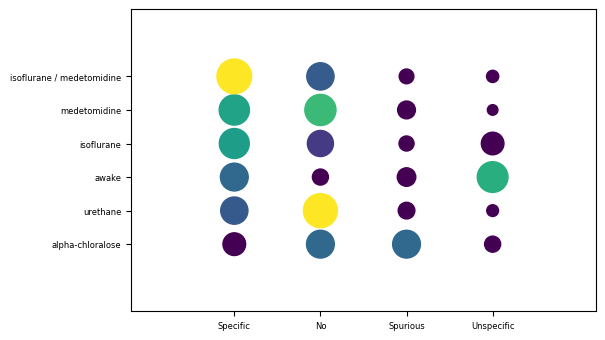

In [158]:
#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby


dfu = df_exclude.groupby(['anesthesia.maintenance', 
                    'GSRs_S1bf_cat']).size()
                    
size_fact=12

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent", 'anesthesia.maintenance': "anesthesia", 'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'])
dfu_pcts['percent'] *= size_fact

plt.scatter(x="category", y='anesthesia', s="percent", c='percent', marker='o',vmin=25*size_fact,vmax=50*size_fact,data=dfu_pcts)
plt.margins(0.4)
plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS6A.svg'), format="svg", dpi=600)
plt.show()

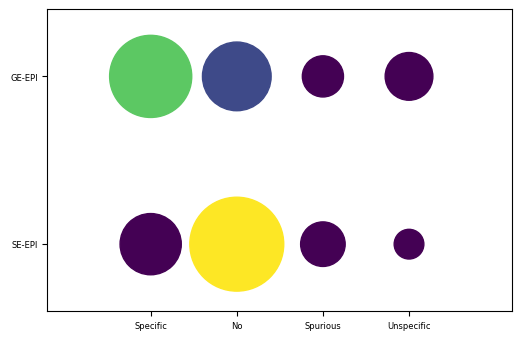

In [159]:

#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby

dfu = df_exclude.groupby(['func.sequence', 
                    'GSRs_S1bf_cat']).size()

size_fact=80                    

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent", 'func.sequence': "sequence", 'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'])
dfu_pcts['percent'] *= size_fact

plt.scatter(x="category", y='sequence', s="percent", c='percent', marker='o',vmin=25*size_fact,vmax=50*size_fact,data=dfu_pcts)
plt.margins(0.4)
plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS6B.svg'), format="svg", dpi=600)
plt.show()

# Manuscript, standardRat part. 
let's re-initialize everything in case I want to only make figures for standardRat

In [160]:
import os
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import pandas as pd
from nilearn import plotting
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.api import qqplot
from scipy.stats import chi2_contingency
from math import sqrt

# init variables
init_folder='/home/traaffneu/joagra/code/MultiRat'
analysis_folder='/project/4180000.19/multiRat'
df_path='../assets/table/standardRat_20220114.tsv'

df = pd.read_csv(df_path, sep='\t')
df['Field_strength'] = pd.Categorical(df.Field_strength)
df_exclude = df.loc[(df['exclude'] != 'yes')]

# color palette for all plots except voxelwise. 
sns.set_palette("colorblind")

## from https://stackoverflow.com/questions/50506076/is-there-an-efficient-way-to-store-2d-plots-as-a-vector-graphic-in-python
new_rc_params = {'text.usetex': False,"svg.fonttype": 'none'}
plt.rcParams.update(new_rc_params)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 6
mm = (1/2.54)*10

# combine jet colormap for plot_stat_map (see https://stackoverflow.com/a/31052741)
# select to color scheme to use
colors1 = plt.cm.jet(np.linspace(0., 1, 128))
colors = np.vstack((colors1, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

# Figure 3 Standard rat
a. Breathing rate
b. tSNR   
c. Mean framewise displacement   
d. FC specificity   
e. FC incidence map   

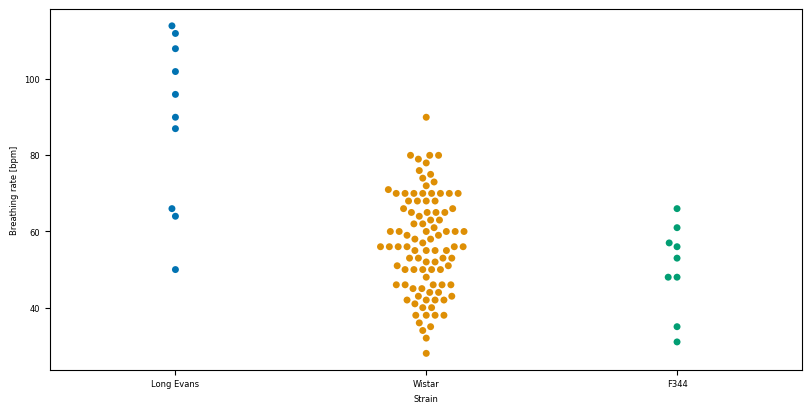

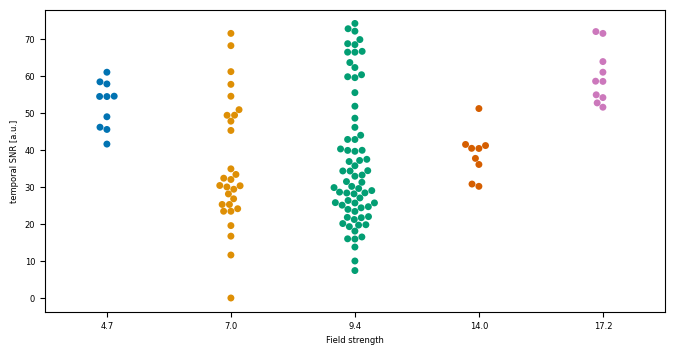

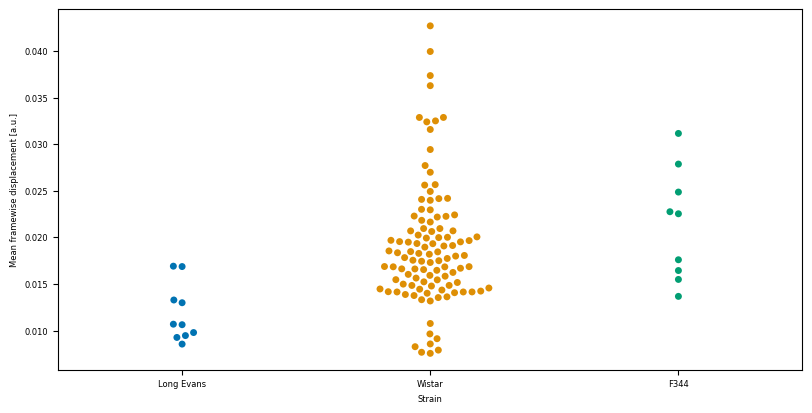

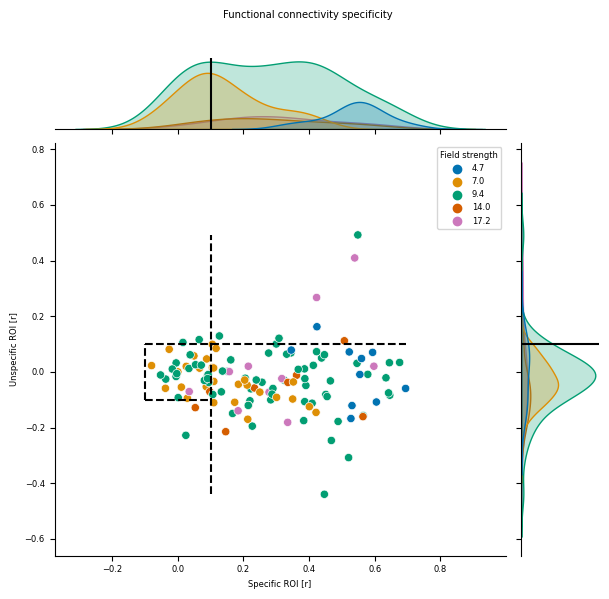

In [34]:

# plot breathing as a function of strain
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4),constrained_layout=True)
sns.set_palette("colorblind")
ax1 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="Breathing_onset")
ax1.set(xlabel='Strain', ylabel='Breathing rate [bpm]')
plt.savefig(os.path.join(init_folder,'assets','figure','Figure3A.svg'), format="svg", dpi=600)
plt.show()

# plot S1 tSNR as a function of acquisition parameters

fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4))
sns.set_palette("colorblind")
ax1 = sns.swarmplot(data=df_exclude, x="Field_strength", y="tsnr.S1")
ax1.set(xlabel='Field strength', ylabel='temporal SNR [a.u.]')
plt.savefig(os.path.join(init_folder,'assets','figure','Figure3B.svg'), format="svg", dpi=600)
plt.show()

# plot MFW as a function of strain
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8, 4),constrained_layout=True)
sns.set_palette("colorblind")
ax1 = sns.swarmplot(data=df_exclude, x="Strain",
                    y="MFW")
ax1.set(xlabel='Strain', ylabel='Mean framewise displacement [a.u.]')
plt.savefig(os.path.join(init_folder,'assets','figure','Figure3C.svg'), format="svg", dpi=600)
plt.show()


ax6 = sns.jointplot(data=df_exclude, x='GSRs_S1bf_S1bf', y='GSRs_S1bf_ACA', hue='Field_strength')

ax6.fig.suptitle('Functional connectivity specificity')
ax6.fig.subplots_adjust(top=0.9)
ax6.ax_joint.set(xlabel='Specific ROI [r]', ylabel='Unspecific ROI [r]')
ax6.ax_joint.get_legend().set_title('Field strength')
ax6.ax_joint.vlines(0.1,ymin=min(df_exclude['GSRs_S1bf_ACA']),ymax=max(df_exclude['GSRs_S1bf_ACA']),linestyles='dashed', color='black')
ax6.ax_joint.vlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(-0.1, -0.1,0.1,linestyles='dashed', color='black')
ax6.ax_joint.hlines(0.1, -0.1,xmax=max(df_exclude['GSRs_S1bf_S1bf']),linestyles='dashed', color='black')
ax6.ax_marg_x.axvline(x=0.1, color='black')
ax6.ax_marg_y.axhline(y=0.1, color='black')
plt.savefig(os.path.join(init_folder,'assets','figure','Figure3D.svg'), format="svg", dpi=600)
plt.show()

# Figure S7 StandardRat parameters. 
a. Sex 
b. Strain
c. Field strength
d. Weight
e. Breathing vs mean framewise displacement
f. specificity


correlation between MFW and breathing
-0.2948895027521542


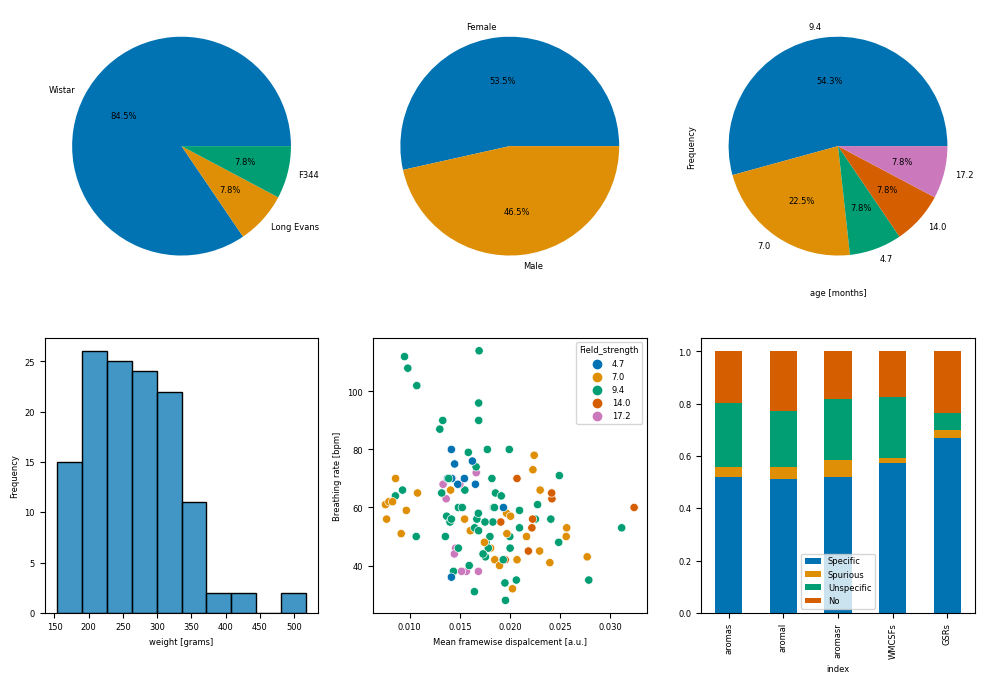

In [161]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))


ax1 = df['Sex'].value_counts().plot.pie(ax=axes[0,1],autopct="%.1f%%")
ax2 = df['Strain'].value_counts().plot.pie(ax=axes[0,0],autopct="%.1f%%")
ax3 = df['Field_strength'].value_counts().plot.pie(ax=axes[0,2], autopct="%.1f%%")
ax4 = sns.histplot(data=df, x="Weight",ax=axes[1,0])
ax5 = sns.scatterplot(data=df_exclude, x="MFW",
                    y="Breathing_onset", hue="Field_strength",ax=axes[1,1])


ax1.set(xlabel="", ylabel="")
ax2.set(xlabel="", ylabel="")
ax3.set(xlabel="age [months]", ylabel="Frequency")
ax4.set(xlabel="weight [grams]", ylabel="Frequency")
ax5.set(xlabel='Mean framewise dispalcement [a.u.]', ylabel='Breathing rate [bpm]', title='')


print('correlation between MFW and breathing')
print(df_exclude[['MFW','Breathing_onset']].corr().iloc[0,1])

specificity_denoise= pd.concat([df_exclude['aromas_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromal_S1bf_cat'].value_counts(sort=False),
                                df_exclude['aromasr_S1bf_cat'].value_counts(sort=False),
                                df_exclude['WMCSFs_S1bf_cat'].value_counts(sort=False),
                                df_exclude['GSRs_S1bf_cat'].value_counts(sort=False)], axis=1)

specificity_denoise = specificity_denoise/specificity_denoise.sum()
specificity_denoise = specificity_denoise.rename(columns={"aromas_S1bf_cat": "aromas", "aromal_S1bf_cat": "aromal", "aromasr_S1bf_cat": "aromasr", "WMCSFs_S1bf_cat": "WMCSFs", "GSRs_S1bf_cat": "GSRs"})

specificity_denoise_T = specificity_denoise.T
specificity_denoise_T.reset_index(level=0, inplace=True) 
specificity_denoise_T = specificity_denoise_T[["index","Specific", "Spurious", "Unspecific","No"]]

specificity_denoise_T.set_index('index').plot(kind='bar', stacked=True,ax=axes[1,2])

plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS7.svg'), format="svg", dpi=600)
plt.show()


# Stats for standardRat

In [92]:
# test for the group difference between strain on breathing rate
import pingouin as pg

df_exclude.anova(dv='Breathing_onset', between='Strain', detailed=False, effsize='n2')

,Source,ddof1,ddof2,F,p-unc,n2
0,Strain,2,114,26.890012,2.712577e-10,0.320539


In [119]:
# test for dependance between tSNR and field strength (linear reg)
import pingouin as pg

lm = pg.linear_regression(df_exclude['Field_strength'], df_exclude['tsnr.S1'])
lm.round(2)
#len(df_exclude['tsnr.S1'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,30.06,4.89,6.15,0.00,0.03,0.03,20.38,39.74
1,Field_strength,1.04,0.49,2.10,0.04,0.03,0.03,0.06,2.02


In [123]:
#compare motion

#re-read the multirat table
df_path_multi='../assets/table/multiRat_rest_20211208.tsv'
df_multi = pd.read_csv(df_path_multi, sep='\t')
df_multi_exclude = df_multi.loc[(df_multi['exclude'] != 'yes')]

df_multi_exclude = df_multi_exclude.loc[(df_multi_exclude['anesthesia.maintenance']=='isoflurane / medetomidine')]


pg.ttest(df_exclude['MFW'],df_multi_exclude['MFW']).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.53,291.35,two-sided,0.6,"[-0.0, 0.0]",0.06,0.147,0.08


In [156]:
#re-read the multirat table
df_path_multi='../assets/table/multiRat_rest_20211208.tsv'
df_multi = pd.read_csv(df_path_multi, sep='\t')
df_multi_exclude = df_multi.loc[(df_multi['exclude'] != 'yes')]

chi_stack = pd.DataFrame([df_multi_exclude['GSRs_S1bf_cat'].value_counts(),df_exclude['GSRs_S1bf_cat'].value_counts()]).assign(dataset=['multirat','standardrat']).set_index('dataset')

g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

             Specific   No  Unspecific  Spurious  sum  Specific_percent
dataset                                                                
standardrat        85   30           8         4  127              0.67
multirat          260  210          86        70  626              0.42
Strain effect: g-value = 29.736495741428932 dof = 3 p-value = 1.5678968453270428e-06 Phi = 0.14


In [36]:
from scipy.stats import chi2_contingency
from math import sqrt

# now testing strain
chi_stack = df_exclude.groupby(['Strain', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Strain effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing sex
chi_stack = df_exclude.groupby(['Sex', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Sex effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing field strength
chi_stack = df_exclude.groupby(['Field_strength', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Field strength effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing anesthesia.breathing.rate
df_exclude['breathing_bin']=pd.cut(df_exclude['Breathing_onset'],6)
chi_stack = df_exclude.groupby(['breathing_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Breathing rate effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


# now testing Mean framewise displacement
df_exclude['MFW_bin']=pd.cut(df_exclude['MFW'],6)
chi_stack = df_exclude.groupby(['MFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Mean framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing Max framewise displacement
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
chi_stack = df_exclude.groupby(['maxFW_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('Max framewise displacement effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))

# now testing tSNR in S1
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
chi_stack = df_exclude.groupby(['tsnr_bin', 
                    'GSRs_S1bf_cat']).size().unstack('GSRs_S1bf_cat')
chi_stack = chi_stack.loc[chi_stack.sum(axis=1) > 0]
chi_stack = chi_stack.fillna(0)
print('')
g, p, dof, expctd  = chi2_contingency(chi_stack)
chi_stack["sum"] = chi_stack.sum(axis=1)
chi_stack["Specific_percent"]= round(chi_stack['Specific']/chi_stack["sum"],2)
print(chi_stack.sort_values(by="Specific_percent",ascending=False))
print('tSNR effect: g-value = '+str(g)+' dof = '+str(dof)+' p-value = '+str(p) + ' Phi = '+ str(round(sqrt(g/chi_stack.sum().sum()),3)))


GSRs_S1bf_cat    No  Specific  Spurious  Unspecific    sum  Specific_percent
Strain                                                                      
Long Evans      0.0      10.0       0.0         0.0   10.0              1.00
Wistar         27.0      71.0       3.0         7.0  108.0              0.66
F344            3.0       4.0       1.0         1.0    9.0              0.44
Strain effect: g-value = 8.285089869281046 dof = 6 p-value = 0.21795206719924753 Phi = 0.18

GSRs_S1bf_cat  No  Specific  Spurious  Unspecific  sum  Specific_percent
Sex                                                                     
Male           10        44         1           4   59              0.75
Female         20        41         3           4   68              0.60
Sex effect: g-value = 3.8206075401247226 dof = 3 p-value = 0.2814982103377415 Phi = 0.122

GSRs_S1bf_cat   No  Specific  Spurious  Unspecific  sum  Specific_percent
Field_strength                                                  

# Figure S8 Chi2 dot plot std
A. breathing rate    
B. tSNR   
C. maximal framewise displacement   

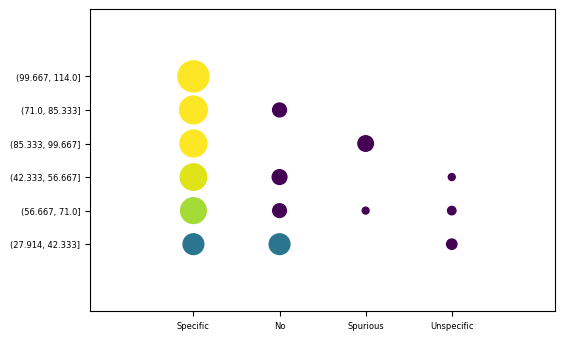

In [162]:
#adapted from https://stackoverflow.com/questions/50399802/python-categorical-bubble-plot and https://stackoverflow.com/questions/23377108/pandas-percentage-of-total-with-groupby
df_exclude['breathing_bin']=pd.cut(df_exclude['Breathing_onset'],6)
dfu = df_exclude.groupby(['breathing_bin', 
                    'GSRs_S1bf_cat']).size()
                    
size_fact=5

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['breathing_bin'] = dfu_pcts['breathing_bin'].astype(str)
dfu_pcts['breathing_bin'] = pd.Categorical(dfu_pcts['breathing_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= size_fact

plt.scatter(x="category", y='breathing_bin', s="percent", c='percent', marker='o',vmin=25*size_fact,vmax=75*size_fact,data=dfu_pcts)
plt.margins(0.4)
plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS8A.svg'), format="svg", dpi=600)
plt.show()

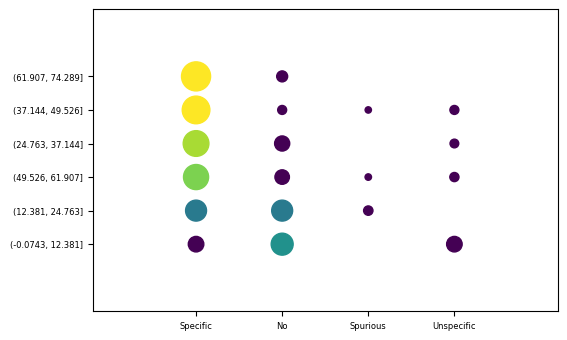

In [163]:
df_exclude['tsnr_bin']=pd.cut(df_exclude['tsnr.S1'],6)
dfu = df_exclude.groupby(['tsnr_bin', 
                    'GSRs_S1bf_cat']).size()

size_fact=5

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['tsnr_bin'] = dfu_pcts['tsnr_bin'].astype(str)
dfu_pcts['tsnr_bin'] = pd.Categorical(dfu_pcts['tsnr_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= size_fact

plt.scatter(x="category", y='tsnr_bin', s="percent", c='percent', marker='o',vmin=25*size_fact,vmax=75*size_fact,data=dfu_pcts)
plt.margins(0.4)
plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS8B.svg'), format="svg", dpi=600)
plt.show()

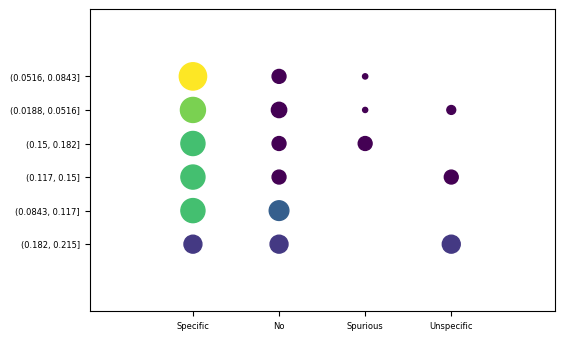

In [164]:
df_exclude['maxFW_bin']=pd.cut(df_exclude['maxFW'],6)
dfu = df_exclude.groupby(['maxFW_bin', 
                    'GSRs_S1bf_cat']).size()
                    
size_fact=5

dfu_pcts = dfu.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).to_frame().reset_index().rename(columns={0: "percent",  'GSRs_S1bf_cat': "category"})
dfu_pcts['category']=pd.Categorical(dfu_pcts['category'], categories=["Specific", "No", "Spurious","Unspecific"], ordered=False)
dfu_pcts['maxFW_bin'] = dfu_pcts['maxFW_bin'].astype(str)
dfu_pcts['maxFW_bin'] = pd.Categorical(dfu_pcts['maxFW_bin'])

dfu_pcts= dfu_pcts.sort_values(by=['category','percent'], ascending=True)
dfu_pcts['percent'] *= size_fact

plt.scatter(x="category", y='maxFW_bin', s="percent", c='percent', marker='o',vmin=25*size_fact,vmax=75*size_fact,data=dfu_pcts)
plt.margins(0.4)
plt.savefig(os.path.join(init_folder,'assets','figure','Sup_FigureS8C.svg'), format="svg", dpi=600)
plt.show()

# Figure 4 Independent component analysis
ICA components, incl labels from the SIGMA atlas. 